---
title: "PCA of low rank matrix of Pan-UKB data"
author: "Saikat Banerjee"
format:
  html: 
      theme: default
      code-fold: show
date: "2024-10-08"
file-modified: "2024-10-08"
abstract: "Using ColormaNN, we obtain the low rank matrix from the noisy input Z scores of Pan-UKB data. Here, we look at the principal components of the estimated low rank matrix."

---

In [6]:
import os
import re
import numpy as np
import pandas as pd
import pickle

from adjustText import adjust_text
import textalloc

In [2]:
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as mpl_fm
font_path = '/gpfs/commons/home/sbanerjee/nygc/Futura'
mpl_fm.fontManager.addfont(font_path + '/FuturaStd-Book.otf') # Loads "Futura Std"

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)
# futura_book = FontProperties(fname='/gpfs/commons/home/sbanerjee/nygc/Futura/FuturaStd-Book.otf')

# NYGC Color Palette
nygc_colors = {
    'brown': '#7F0814',
    'darkred': '#d42e12',
    'orange': '#F37239',
    'darkyellow': '#F79320',
    'yellow': '#FFE438',
    'darkblue': '#003059',
    'blue': '#266DB6',
    'lightblue': '#A3D5ED',
    'darkgreen': '#006838',
    'green': '#0A8A42',
    'lightgreen': '#74B74A',
    'yellowgreen': '#BAD75F',
    'darkgray': '#1A1A1A',
    'gray': '#666666',
    'lightgray': '#CCCCCC',
    'khaki': '#ADA194',
    'darkkhaki': '#5E514D',
}

# Style sheet for NYGC poster
mpl_stylesheet.banskt_presentation(dpi = 300, fontsize = 28, 
    splinecolor = nygc_colors['darkgray'], black = nygc_colors['darkgray'])
plt.rcParams['font.family'] = 'Futura Std'

In [3]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/npddata/panukb/results/colormann-svd"

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all_with_desc.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df = pd.read_csv(variant_filename, sep = '\t')

nsample_filename = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data/phe2483.SampleN.tsv"
nsample_df = pd.read_csv(nsample_filename, sep = '\t')

In [4]:
methods = ["nnm", "nnm-sparse", "rpca"]
method_names = {
    "nnm" : "NNM",
    "nnm-sparse" : "NNM-Sparse",
    "rpca" : "Robust PCA"
}

res_pklfile = {
    "nnm": "nnm_model_r155872_iter1000.pkl",
    "nnm-sparse": "nnm_sparse_model_r155872_iter1000.pkl",
    "rpca": "rpca_model.pkl"
}

pca_comps = dict()
mf_comps = dict()
k = 200

for method in methods:
    comps_filename = os.path.join(result_dir, method, "noRx", "pca_comps.pkl")
    with open(comps_filename, "rb") as mfile:
        pca_comps[method] = pickle.load(mfile)
    mf_comps_filename = os.path.join(result_dir, method, "noRx", f"mf_comps_k{k}.pkl")
    with open(mf_comps_filename, "rb") as mfile:
        mf_comps[method] = pickle.load(mfile)
        
X = np.array(zscore_df.values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

In [5]:
pheno_zindex = [int(x[1:]) for x in zscore_df.columns]
trait_df_noRx = trait_df.loc[trait_df['zindex'].isin(pheno_zindex)]
nsample_df_noRx = nsample_df.loc[trait_df_noRx.index]
trait_df_noRx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2110 entries, 0 to 2482
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zindex                       2110 non-null   int64  
 1   trait_type                   2110 non-null   object 
 2   phenocode                    2110 non-null   object 
 3   pheno_sex                    2110 non-null   object 
 4   coding                       267 non-null    object 
 5   modifier                     394 non-null    object 
 6   description                  2110 non-null   object 
 7   description_more             1408 non-null   object 
 8   coding_description           261 non-null    object 
 9   category                     2072 non-null   object 
 10  BIN_QT                       2110 non-null   object 
 11  n_cases_EUR                  2110 non-null   int64  
 12  n_controls_EUR               1304 non-null   float64
 13  N                      

In [7]:
import scipy.stats as sc_stats
import collections

def q1(x, axis = None):
    return np.percentile(x, 25, axis = axis)

def q3(x, axis = None):
    return np.percentile(x, 75, axis = axis)

def iqr_outlier(x, axis = None, bar = 1.5, side = 'both'):
    assert side in ['gt', 'lt', 'both'], 'Side should be `gt`, `lt` or `both`.'

    d_iqr = sc_stats.iqr(x, axis = axis)
    d_q1 = q1(x, axis = axis)
    d_q3 = q3(x, axis = axis)
    iqr_distance = np.multiply(d_iqr, bar)

    stat_shape = list(x.shape)

    if isinstance(axis, collections.abc.Iterable):
        for single_axis in axis:
            stat_shape[single_axis] = 1
    else:
        stat_shape[axis] = 1

    if side in ['gt', 'both']:
        upper_range = d_q3 + iqr_distance
        upper_outlier = np.greater(x - upper_range.reshape(stat_shape), 0)
    if side in ['lt', 'both']:
        lower_range = d_q1 - iqr_distance
        lower_outlier = np.less(x - lower_range.reshape(stat_shape), 0)

    if side == 'gt':
        return upper_outlier
    if side == 'lt':
        return lower_outlier
    if side == 'both':
        return np.logical_or(upper_outlier, lower_outlier)

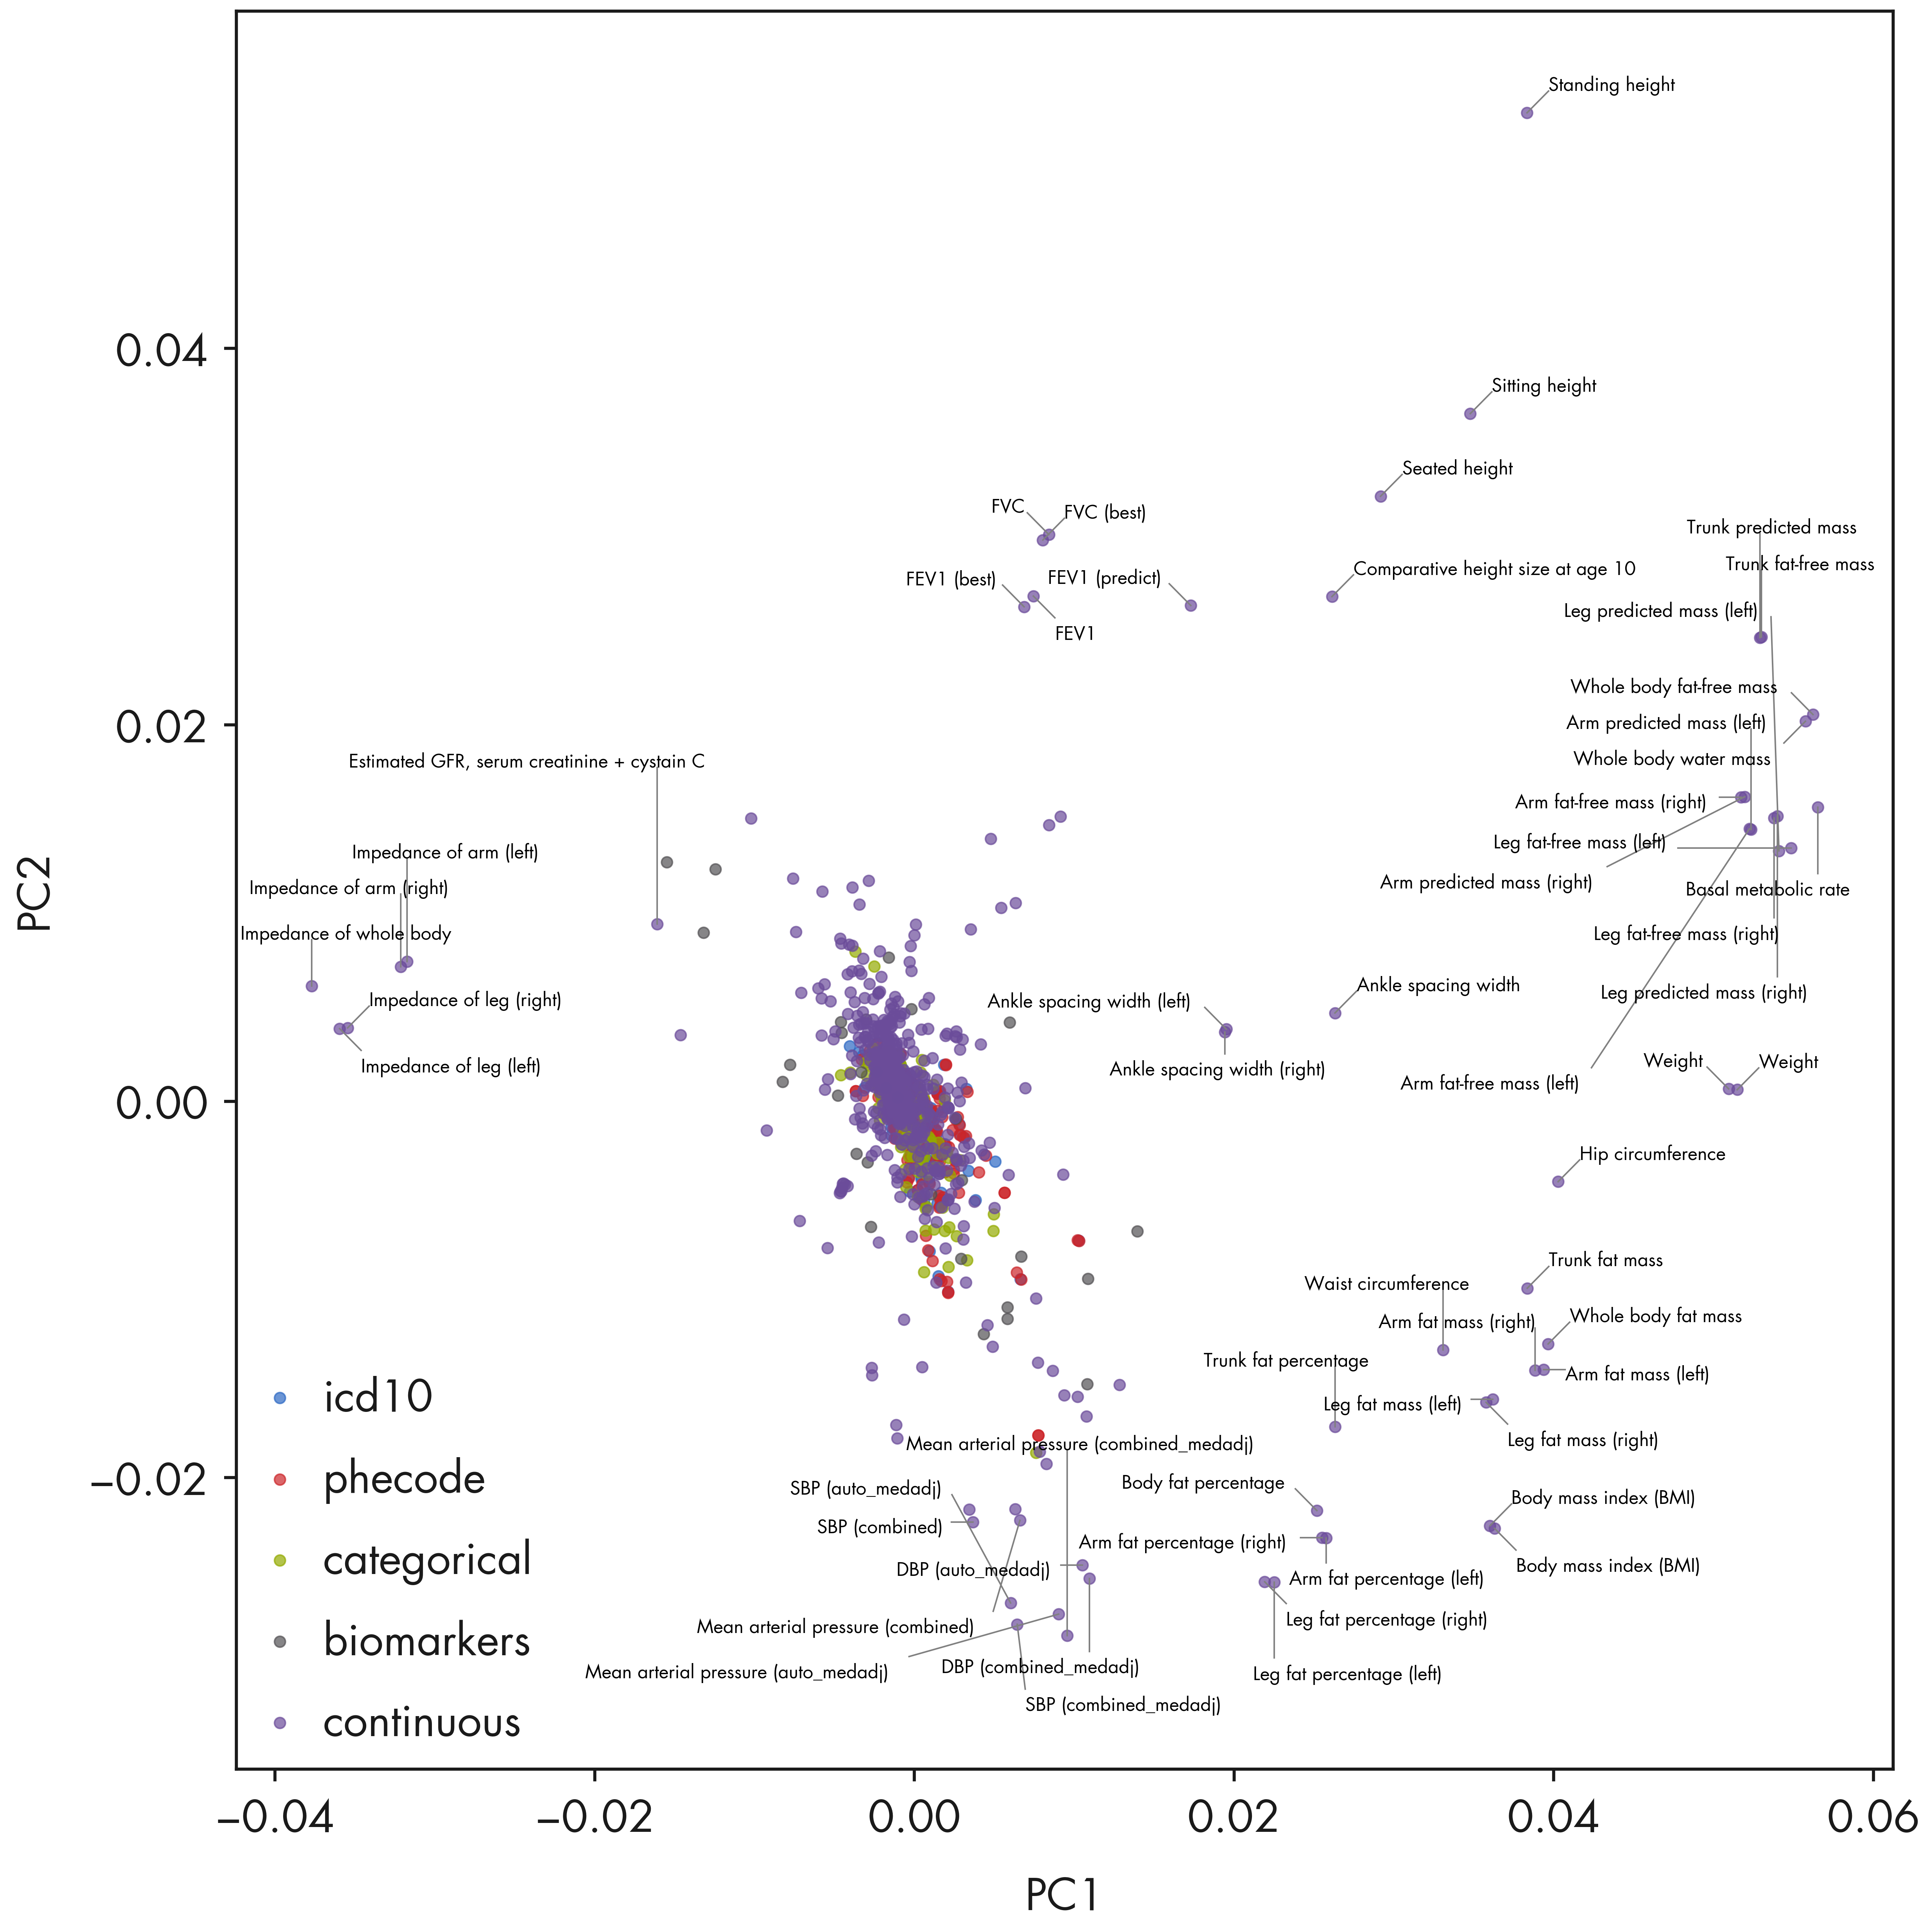

In [28]:
fig = plt.figure(figsize = (18, 18))
ax1 = fig.add_subplot(111)
method = 'nnm_sparse'
ipc1 = 0
ipc2 = 1
trait_indices = np.array(trait_df_noRx.index)
trait_types   = trait_df_noRx['trait_type'].unique().tolist()
trait_colors = {trait: color for trait, color 
                    in zip(trait_types, mpl_stylesheet.banskt_colors()[:len(trait_types)])}

pcomps = mf_comps["rpca"][0]

for t in trait_types:
    selectidx = np.array(trait_df_noRx[trait_df_noRx['trait_type'] == t].index)
    tidx = np.searchsorted(trait_indices, selectidx)
    xvals = pcomps[tidx, ipc1]
    yvals = pcomps[tidx, ipc2]
    ax1.scatter(xvals, yvals, alpha = 0.7, color = trait_colors[t], label = t, s = 50)
    ax1.legend(loc = 'lower left')
    

# Combine outliers in x-axis and y-axis
xvals = pcomps[:, ipc1]
yvals = pcomps[:, ipc2]
outlier_idx_x = np.where(iqr_outlier(xvals, axis = 0, bar = 10.0))[0]
outlier_idx_y = np.where(iqr_outlier(yvals, axis = 0, bar = 10.0))[0]
outlier_idx = np.union1d(outlier_idx_x, outlier_idx_y)
x_center = np.mean(ax1.get_xlim())

# # Mark using adjustText package
# # https://github.com/Phlya/adjustText
# annots = []
# for i in outlier_idx:
#     txt = trait_df.loc[trait_indices[i]]['description'].strip()
#     if 'intima-medial thickness' in txt:
#         continue
#     if xvals[i] > x_center:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 6, ha = 'right')]
#     else:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 6)]
# # Adjust the annotations iteratively
# adjust_text(annots, arrowprops=dict(arrowstyle='-', color = 'grey'))

# Mark using textalloc package
txt_list = []
text_idx_list = []
for i in outlier_idx:
    txt = trait_df_noRx.loc[trait_indices[i]]['short_description'].strip()
    #if 'intima-medial thickness' in txt:
    #    continue
    txt_list.append(txt)
    text_idx_list.append(i)
if len(text_idx_list) > 0:
    txt_idx = np.array(text_idx_list)
    textalloc.allocate_text(fig, ax1, xvals[txt_idx], yvals[txt_idx], txt_list,
                            x_scatter = xvals, y_scatter = yvals,
                            textsize = 12, textcolor = 'black', linecolor = 'grey')

ax1.set_xlabel(f"PC{ipc1 + 1}")
ax1.set_ylabel(f"PC{ipc2 + 1}")
    
plt.tight_layout()
plt.show()